# Heart Attack Prediction

**Programmazione di Applicazioni Data Intensive**

**Lorenzo Dall'Ara**, lorenzo.dallara2@studio.unibo.it\
**Miriam Sonaglia**, miriam.sonaglia@studio.unibo.it

### Fonti Dataset:
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-dataset-of-china \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india/data \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-indonesia

## Obiettivo del progetto

Questo progetto si pone l'obiettivo di realizzare un modello in grado di predire, in base a caratteristiche proprie del paziente, un possibile rischio di infarto.

## Import delle librerie
Vengono importate le librerie sotto descritte:
* **Pandas** per manipolazione e gestione di dati tabellari
* **Sklearn** per l'analisi predittiva
* **Matplotlib** per la creazione di grafici

In [82]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix,
    precision_score, recall_score, f1_score,
    accuracy_score, matthews_corrcoef
)

In [83]:
CHINA_DATASET = "heart_attack_china.csv"
US_DATASET = "heart_attack_us.csv"
INDIA_DATASET = "heart_attack_india.csv"
INDONESIA_DATASET = "heart_attack_indonesia.csv"
china = pd.read_csv(CHINA_DATASET, sep=",")
unitedStates = pd.read_csv(US_DATASET, sep=",")
india = pd.read_csv(INDIA_DATASET, sep=",")
indonesia = pd.read_csv(INDONESIA_DATASET, sep=",")

In [84]:
# FUNZIONE PER OUTCOME TRUE PER OGNI VALORE
targetCorrelation = lambda df, key, targetKey='Outcome': df.groupby(key, observed=False)[targetKey].mean()*100

## Caricamento e Preprocessing dei dati
### Scelta e Denominazione delle colonne
Si è proceduto alla selezione delle variabili compatibili tra i quattro dataset, individuandone le colonne comuni e rinominandole in modo univoco.

Le colonne scelte sono quindi:
* **PatientID**: identificatore univoco del paziente
* **Age**: età del paziente
* **Gender**: genere del paziente, può assumere i valori "Male" o "Female"
* **IncomeLevel**: guadagno annuo del paziente, può assumere i valori "Low", "Middle" o "High"
* **Hypertension**: indica se il paziente soffre o meno di ipertensione arteriosa
* **Diabetes**: indica se il paziente soffre o meno di diabete
* **Cholesterol**: indica il livello di colesterolo del paziente, può assumere i valori "Low", "Normal" o "High"
* **Obesity**: indica se il paziente sia affetto o meno da obesità (AFFETTO DA??????????)
* **FamilyHistory**: indica se qualche membro della famiglia del paziente abbia avuto o meno un infarto in passato
* **Smoker**: indica se il paziente sia o meno un fumatore
* **AlcoholConsumption**: indica se il paziente sia tendente o meno al consumo di alcohol
* **PhysicalActivity**: indica se il paziente svolge o meno attività fisica
* **HealthyDiet**: indica se il paziente segua o meno una dieta sana
* **StressLevel**: indica il livello di stress del paziente, può assumere i valori 'Low', 'Moderate' o 'High'
* **BloodPressure**: indica il valore della pressione sistolica del paziente
* **PreviousHeartAttack**: indica se il paziente abbia avuto o meno altri infarti in passato
* **Outcome**: indica se il paziente abbia avuto o meno un infarto
* **State**: indica lo stato di provenienza del paziente (Cina, Stati Uniti, India, Indonesia)

In [85]:
china['State'] = "China"
india['State'] = "India"
unitedStates['State'] = "United States"
indonesia['State'] = "Indonesia"

unitedStates["PatientID"] = range(1, len(unitedStates)+1)
indonesia["PatientID"] = range(1, len(indonesia)+1)

In [86]:
(
    unitedStates.drop(
        columns = ['EducationLevel',
                   'ST_Depression',
                   'EmploymentStatus',
                   'MaritalStatus',
                   'Ethnicity',
                   'Medication',
                   'ChestPainType',
                   'ECGResults',
                   'ExerciseInducedAngina',
                   'Slope',
                   'NumberOfMajorVessels',
                   'Thalassemia',
                   'StrokeHistory',
                   'Residence',
                   'MaxHeartRate',
                   'HeartRate'
                  ],
        inplace=True
    )
)

In [87]:
unitedStates.rename(columns = {'BMI':'Obesity', 'Income':'IncomeLevel', 'Patient_ID':'PatientID', 'Diet':'HealthyDiet'}, inplace=True)

In [88]:
(
    china.drop(
        columns = ['Education_Level',
                   'Employment_Status',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Rural_or_Urban',
                   'Region',
                   'Province',
                   'Hospital_Availability',
                   'TCM_Use',
                   'Chronic_Kidney_Disease',
                   'CVD_Risk_Score'
                  ],
        inplace=True
    )
)

In [89]:
china.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking_Status':'Smoker',
        'Cholesterol_Level':'Cholesterol',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Income_Level':'IncomeLevel',
        'Blood_Pressure':'BloodPressure',
        'Previous_Heart_Attack': 'PreviousHeartAttack',
        'Family_History_CVD': 'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Heart_Attack' : 'Outcome'
    },
    inplace=True
)

In [90]:
(
    india.drop(
        columns = ['State_Name',
                   'Triglyceride_Level',
                   'LDL_Level',
                   'HDL_Level',
                   'Diastolic_BP',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Emergency_Response_Time',
                   'Health_Insurance'
                  ],
        inplace=True
    )
)

In [91]:
india.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking':'Smoker',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Cholesterol_Level':'Cholesterol',
        'Systolic_BP':'BloodPressure',
        'Family_History':'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Heart_Attack_History':'PreviousHeartAttack',
        'Annual_Income':'IncomeLevel',
        'Heart_Attack_Risk':'Outcome'
    },
    inplace=True
)

In [92]:
(
    indonesia.drop(
        columns = ['region',
                   'waist_circumference',
                   'air_pollution_exposure',
                   'sleep_hours',
                   'blood_pressure_diastolic',
                   'fasting_blood_sugar',
                   'cholesterol_hdl',
                   'cholesterol_ldl',
                   'triglycerides',
                   'EKG_results',
                   'medication_usage',
                   'participated_in_free_screening'
                  ],
        inplace=True
    )
)

In [93]:
indonesia.rename(
    columns = {
        'age':'Age',
        'gender':'Gender',
        'income_level': 'IncomeLevel',
        'hypertension':'Hypertension',
        'diabetes':'Diabetes',
        'cholesterol_level':'Cholesterol',
        'obesity':'Obesity',
        'family_history':'FamilyHistory',
        'smoking_status':'Smoker',
        'alcohol_consumption':'AlcoholConsumption',
        'physical_activity':'PhysicalActivity',
        'dietary_habits':'HealthyDiet',
        'stress_level':'StressLevel',
        'blood_pressure_systolic':'BloodPressure',
        'previous_heart_disease':'PreviousHeartAttack',
        'heart_attack':'Outcome',
    },
    inplace=True
)

In [94]:
dfs = {
    "China": china,
    "India": india,
    "United States": unitedStates,
    "Indonesia" : indonesia
}

# insieme di tutte le colonne
all_columns = set().union(*(df.columns for df in dfs.values()))

# colonne mancanti per ogni dataset
diff_columns = {
    name: sorted(all_columns - set(df.columns))
    for name, df in dfs.items()
}

diff_columns

{'China': [], 'India': [], 'United States': [], 'Indonesia': []}

### Uniformazione dei tipi di dato
Si è proceduto alla standardizzazione del formato dei dati per ogni colonna, al fine di prevenire incongruenze durante l'elaborazione.

### Ottimizzazione dei dati   (VEDI SE METTERE QUA O SOTTO)
Al fine di migliorare l'efficienza computazionale, è stato effettuato il downcasting di alcune variabili numeriche, convertendo il formato da `int64` a `int16`, riducendo così il peso complessivo del database.

In [95]:
initial_memory = china.memory_usage(deep=True).sum()

china['Age'] = china['Age'].astype('int16')
china['BloodPressure'] = china['BloodPressure'].astype('int16')
china['Gender'] = china['Gender'].astype('category')
china['Smoker'] = china['Smoker'].map({'Smoker':True, 'Non-Smoker':False}).astype('bool')
china["Hypertension"] = china["Hypertension"].map({"Yes": True, "No": False}).astype('bool')
china["Diabetes"] = china["Diabetes"].map({"Yes": True, "No": False}).astype('bool')
china["Obesity"] = china["Obesity"].map({"Yes": True, "No": False}).astype('bool')
china['Cholesterol'] = china['Cholesterol'].astype('category')
china['PhysicalActivity'] = china['PhysicalActivity'].map({"High": True, "Medium": True, "Low": False})
china['HealthyDiet'] = china['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Poor": False})
china['StressLevel'] = china['StressLevel'].map({'Low':'Low', 'Medium':'Moderate', 'High':'High'}).astype('category')
china['AlcoholConsumption'] = china['AlcoholConsumption'].map({'Yes':True, 'No':False}).astype('bool')
china['FamilyHistory'] = china['FamilyHistory'].map({'Yes':True, 'No':False}).astype('bool')
china['IncomeLevel'] = china['IncomeLevel'].astype('category')
china['PreviousHeartAttack'] = china['PreviousHeartAttack'].map({'Yes':True, 'No':False}).astype('bool')
china['Outcome'] = china['Outcome'].map({'Yes':True, 'No':False}).astype('bool')
china['State'] = china['State'].astype('category')

end_memory = china.memory_usage(deep=True).sum()
china.dtypes

PatientID                 int64
Age                       int16
Gender                 category
Smoker                     bool
Hypertension               bool
Diabetes                   bool
Obesity                    bool
Cholesterol            category
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
AlcoholConsumption         bool
FamilyHistory              bool
IncomeLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
State                  category
dtype: object

In [96]:
china_memory_optimization_coeff = initial_memory / end_memory
china_memory_optimization_coeff

np.float64(30.220518988011758)

In [97]:
initial_memory = unitedStates.memory_usage(deep=True).sum()

unitedStates['Age'] = unitedStates['Age'].astype('int16')
unitedStates['BloodPressure'] = unitedStates['BloodPressure'].astype('int16')
unitedStates['Gender'] = unitedStates['Gender'].astype('category')

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
unitedStates['Cholesterol'] = pd.cut(
    unitedStates['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

unitedStates['Obesity'] = unitedStates['Obesity'] >= 30
unitedStates['Smoker'] = unitedStates['Smoker'].map({1:True, 0:False}).astype('bool')
unitedStates['Diabetes'] = unitedStates['Diabetes'].map({1:True, 0:False}).astype('bool')
unitedStates['Hypertension'] = unitedStates['Hypertension'].map({1:True, 0:False}).astype('bool')
unitedStates['FamilyHistory'] = unitedStates['FamilyHistory'].map({1:True, 0:False}).astype('bool')
unitedStates['PhysicalActivity'] = unitedStates['PhysicalActivity'] > 2
unitedStates['AlcoholConsumption'] = unitedStates['AlcoholConsumption'] > 2
unitedStates['HealthyDiet'] = unitedStates['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Unhealthy": False})

bins = [0, 2, 4, 10]
labels = ['Low', 'Moderate', 'High']
unitedStates['StressLevel'] = pd.cut(
    unitedStates['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

bins = [0, 60000, 100000, float("inf")]
labels = ["Low", "Middle", "High"]

unitedStates["IncomeLevel"] = pd.cut(
    unitedStates["IncomeLevel"],
    bins=bins,
    labels=labels,
    right=False
)

unitedStates['PreviousHeartAttack'] = unitedStates['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
unitedStates['Outcome'] = unitedStates['Outcome'].map({'Heart Attack':True, 'No Heart Attack':False}).astype('bool')

end_memory = unitedStates.memory_usage(deep=True).sum()
unitedStates.dtypes

Age                       int16
Gender                 category
Cholesterol            category
BloodPressure             int16
Obesity                    bool
Smoker                     bool
Diabetes                   bool
Hypertension               bool
FamilyHistory              bool
PhysicalActivity           bool
AlcoholConsumption         bool
HealthyDiet                bool
StressLevel            category
IncomeLevel            category
PreviousHeartAttack        bool
Outcome                    bool
State                    object
PatientID                 int64
dtype: object

In [98]:
us_memory_optimization_coeff = initial_memory / end_memory
us_memory_optimization_coeff

np.float64(3.948718463524788)

In [99]:
initial_memory = india.memory_usage(deep=True).sum()

india['Age'] = india['Age'].astype('int16')
india['BloodPressure'] = india['BloodPressure'].astype('int16')
india['Gender'] = india['Gender'].astype('category')
india['Diabetes'] = india['Diabetes'].map({1:True, 0:False}).astype('bool')
india['Hypertension'] = india['Hypertension'].map({1:True, 0:False}).astype('bool')
india['Obesity'] = india['Obesity'].map({1:True, 0:False}).astype('bool')
india['Smoker'] = india['Smoker'].map({1:True, 0:False}).astype('bool')
india['AlcoholConsumption'] = india['AlcoholConsumption'].map({1:True, 0:False}).astype('bool')
india['PhysicalActivity'] = india['PhysicalActivity'].map({1:True, 0:False}).astype('bool')
india['HealthyDiet'] = india['HealthyDiet'] > 4

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
india['Cholesterol'] = pd.cut(
    india['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

india['FamilyHistory'] = india['FamilyHistory'].map({1:True, 0:False}).astype('bool')

bins = [0, 3, 7, 11]
labels = ['Low', 'Moderate', 'High']
india['StressLevel'] = pd.cut(
    india['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

india['PreviousHeartAttack'] = india['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')

bins = [0, 300000, 1000000, float('inf')]
labels = ["Low", "Middle", "High"]

india["IncomeLevel"] = pd.cut(
    india["IncomeLevel"],
    bins=bins,
    labels=labels,
    right=False
)

india['Outcome'] = india['Outcome'].map({1:True, 0:False}).astype('bool')
india['State'] = india['State'].astype('category')

end_memory = india.memory_usage(deep=True).sum()
india.dtypes

PatientID                 int64
Age                       int16
Gender                 category
Diabetes                   bool
Hypertension               bool
Obesity                    bool
Smoker                     bool
AlcoholConsumption         bool
PhysicalActivity           bool
HealthyDiet                bool
Cholesterol            category
BloodPressure             int16
FamilyHistory              bool
StressLevel            category
PreviousHeartAttack        bool
IncomeLevel            category
Outcome                    bool
State                  category
dtype: object

In [100]:
india_memory_optimization_coeff = initial_memory / end_memory
india_memory_optimization_coeff

np.float64(8.69502720075484)

In [101]:
initial_memory = indonesia.memory_usage(deep=True).sum()

indonesia['Age'] = indonesia['Age'].astype('int16')
indonesia['BloodPressure'] = indonesia['BloodPressure'].astype('int16')
indonesia['Gender'] = indonesia['Gender'].astype('category')
indonesia['IncomeLevel'] = indonesia['IncomeLevel'].astype('category')
indonesia['Hypertension'] = indonesia['Hypertension'].map({1:True, 0:False}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({1:True, 0:False}).astype('bool')

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
indonesia['Cholesterol'] = pd.cut(
    indonesia['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

indonesia['Obesity'] = indonesia['Obesity'].map({1:True, 0:False}).astype('bool')
indonesia['FamilyHistory'] = indonesia['FamilyHistory'].map({1:True, 0:False}).astype('bool')
indonesia['Smoker'] = indonesia['Smoker'].map({'Past':True,'Current':True, 'Never':False}).astype('bool')
indonesia['AlcoholConsumption'] = indonesia['AlcoholConsumption'].map({None: False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['PhysicalActivity'] = indonesia['PhysicalActivity'].map({'Low': False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
indonesia['StressLevel'] = indonesia['StressLevel'].astype('category')
indonesia['PreviousHeartAttack'] = indonesia['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
indonesia['Outcome'] = indonesia['Outcome'].map({1:True, 0:False}).astype('bool')
indonesia['State'] = indonesia['State'].astype('category')
indonesia['HealthyDiet'] = indonesia['HealthyDiet'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
end_memory = indonesia.memory_usage(deep=True).sum()
indonesia.dtypes

Age                       int16
Gender                 category
IncomeLevel            category
Hypertension               bool
Diabetes                   bool
Cholesterol            category
Obesity                    bool
FamilyHistory              bool
Smoker                     bool
AlcoholConsumption         bool
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
State                  category
PatientID                 int64
dtype: object

In [102]:
indonesia_memory_optimization_coeff = initial_memory / end_memory
indonesia_memory_optimization_coeff

np.float64(18.79193645872424)

I campi `PatientID` e `State` sono identificatori univoci del paziente, senza rilevanza ai fini del modello, è stato scelto quindi di impostarli come `index`

In [103]:
china.set_index(['State','PatientID'], inplace=True)
unitedStates.set_index(['State','PatientID'], inplace=True)
india.set_index(['State','PatientID'], inplace=True)
indonesia.set_index(['State','PatientID'], inplace=True)
dataset = pd.concat([china, india, unitedStates, indonesia], verify_integrity=False)
dataset['Cholesterol'] = dataset['Cholesterol'].astype('category')
dataset['StressLevel'] = dataset['StressLevel'].astype('category')
dataset['IncomeLevel'] = dataset['IncomeLevel'].astype('category')

In [104]:
dataset.dtypes

Age                       int16
Gender                 category
Smoker                     bool
Hypertension               bool
Diabetes                   bool
Obesity                    bool
Cholesterol            category
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
AlcoholConsumption         bool
FamilyHistory              bool
IncomeLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
dtype: object

### Verifica dei record dal valore `NaN`

In [105]:
dataset.isna().mean() * 100 # Verifica percentuale record contenenti un NaN

Age                    0.0
Gender                 0.0
Smoker                 0.0
Hypertension           0.0
Diabetes               0.0
Obesity                0.0
Cholesterol            0.0
PhysicalActivity       0.0
HealthyDiet            0.0
StressLevel            0.0
AlcoholConsumption     0.0
FamilyHistory          0.0
IncomeLevel            0.0
BloodPressure          0.0
PreviousHeartAttack    0.0
Outcome                0.0
dtype: float64

In [106]:
dataset[dataset.isna().any(axis=1)].count().sum() # Trova e conta le righe corrotte

np.int64(0)

In [107]:
(dataset.memory_usage(deep=True).sum() / 1024**2)

np.float64(28.031519889831543)

### Verifica dello sbilanciamento del dataset
Viene ora effettuata una verifica dello sbilanciamento del dataset per evitare di incorrere in previsioni influenzate dalla prevalenza statistica di alcune classi rispetto ad altre.\
Una distribuzione non uniforme, infatti, potrebbe introdurre distorsioni (bias) nelle fasi di training.\
Per garantire che il modello finale sia in grado di generalizzare correttamente su tutte le categorie è quindi fondamentale identificare eventuali squilibri.

In [108]:
dataset['Outcome'].value_counts(normalize=True) * 100 # Verifica se il dataset è sbilanciato

Outcome
False    63.887163
True     36.112837
Name: proportion, dtype: float64

<Axes: ylabel='Outcome'>

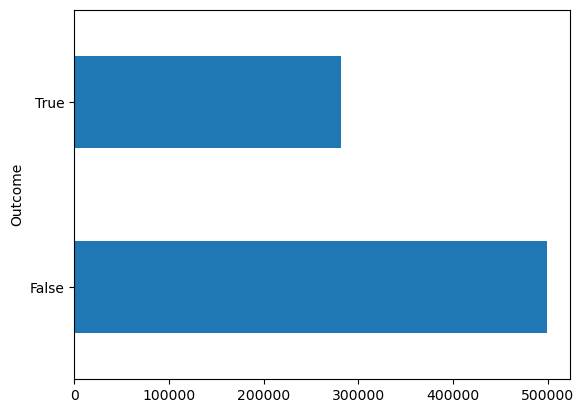

In [109]:
dataset['Outcome'].value_counts().plot.barh()

In [110]:
dataset.groupby('Gender', observed=True)['Outcome'].mean() # Se la percentuale è grande può causare leakage

Gender
Female    0.361486
Male      0.360777
Name: Outcome, dtype: float64

In [111]:
dataset.groupby('Gender', observed=True).size()

Gender
Female    386748
Male      393847
dtype: int64

In [112]:
dataset.describe()

,Age,BloodPressure
count,780595.000000,780595.000000
mean,57.148379,133.499806
std,15.778362,24.248001
min,20.000000,61.000000
25%,44.000000,114.000000
50%,57.000000,133.000000
75%,70.000000,153.000000
max,90.000000,199.000000


### Verifica della presenza di valori outlier

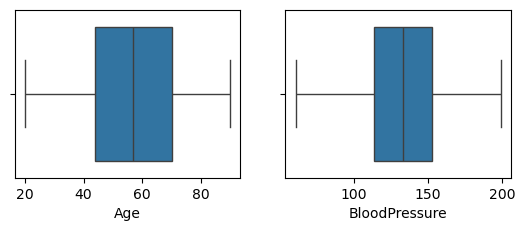

In [113]:
plt.subplot(2,2,1)
sb.boxplot(x="Age", data=dataset);

plt.subplot(2,2,2)
sb.boxplot(x="BloodPressure", data=dataset);

Dai grafici possiamo notare che le feature `Age` e `BloodPressure` non presentano valori outlier.

### Analisi dei legami tra feature

Vengono in seguito riportati dei grafici che mostrano la distribuzione dell'Outcome (True/False) rispetto ad alcune feature presenti nel dataset.

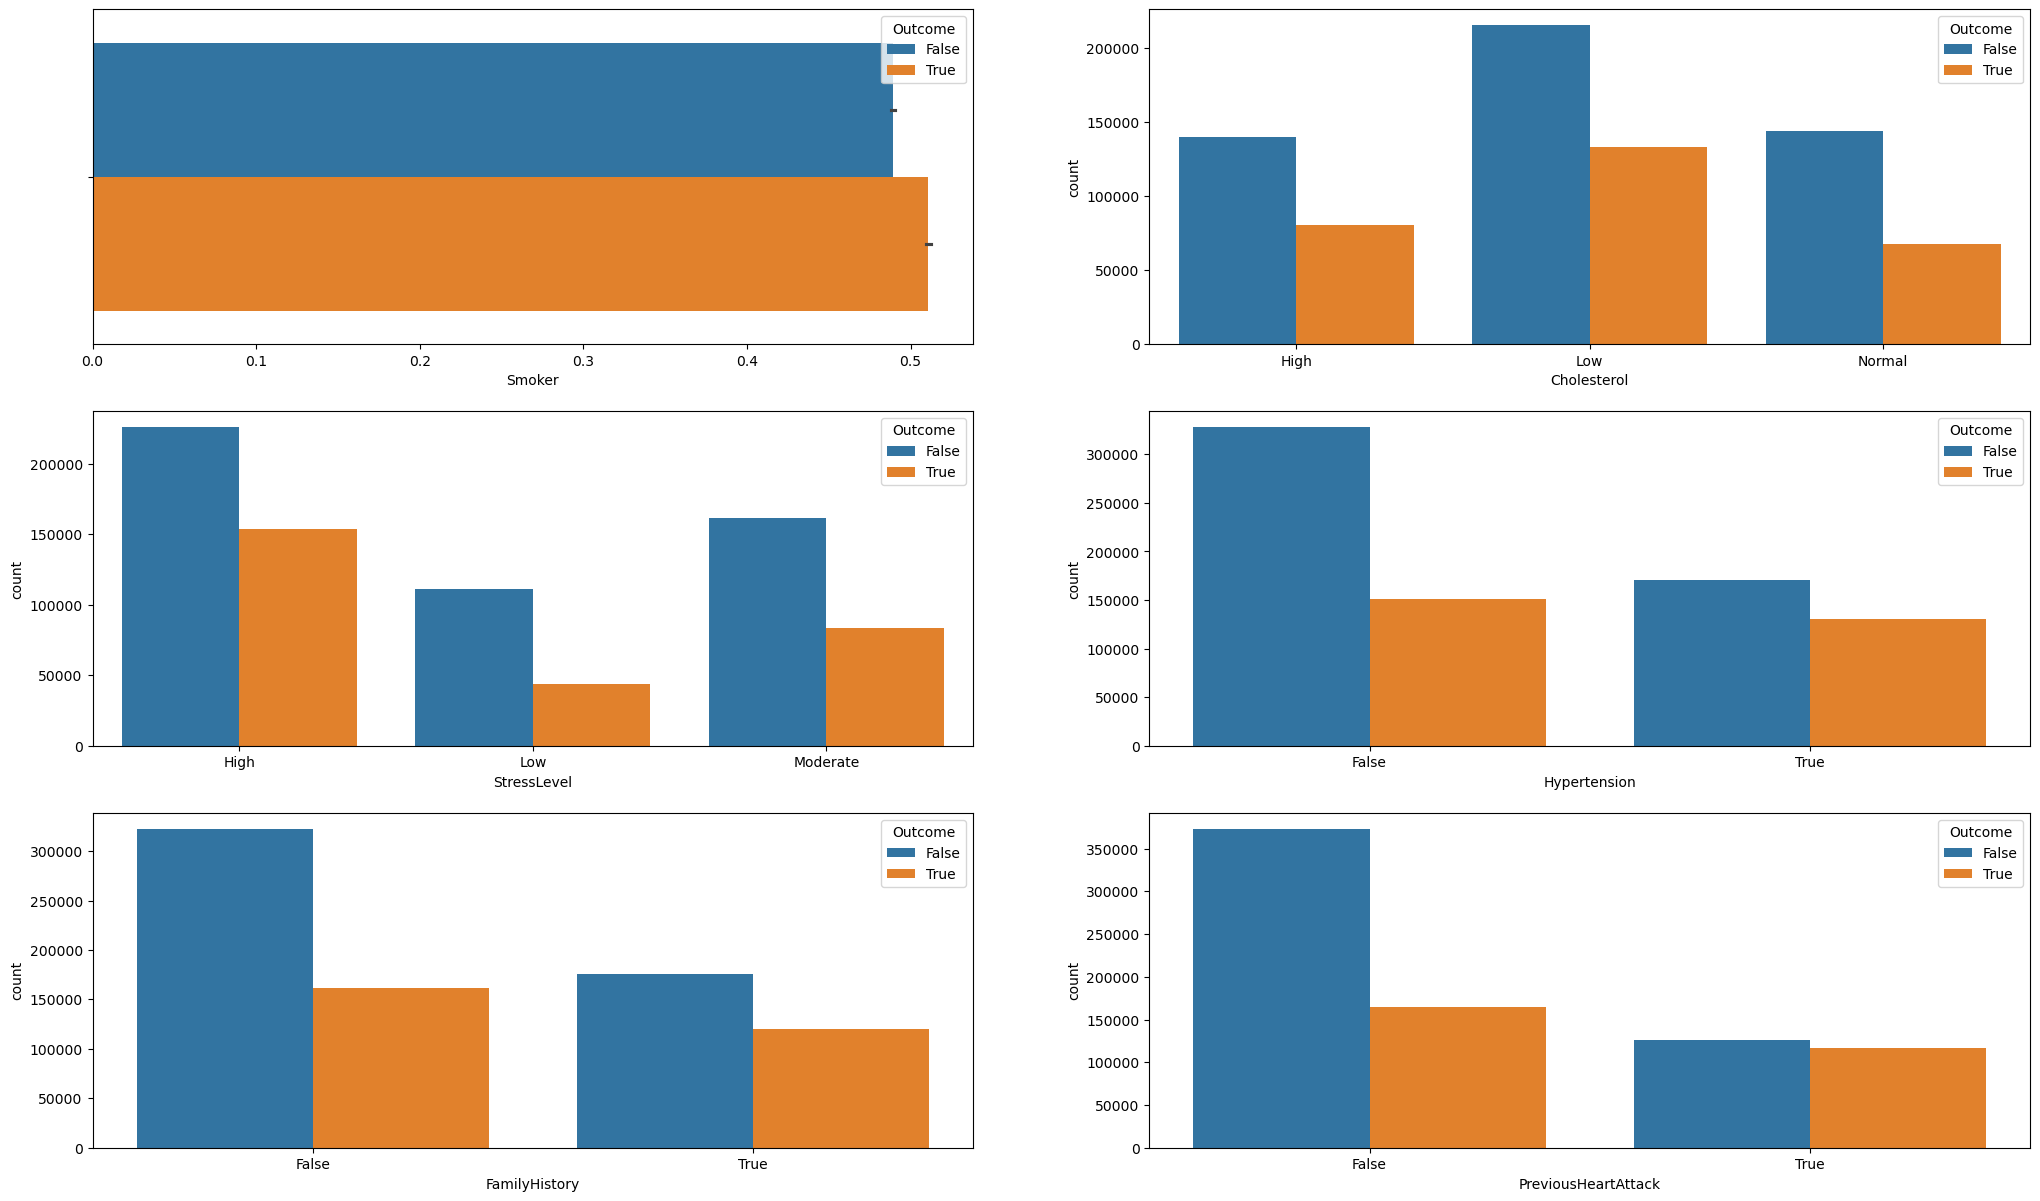

In [114]:
plt.figure(figsize=(25,20))

plt.subplot(4,2,1)
sb.barplot(x='Smoker', hue='Outcome', data = dataset);

plt.subplot(4,2,2)
sb.countplot(x='Cholesterol', hue='Outcome', data = dataset);

plt.subplot(4,2,3)
sb.countplot(x='StressLevel', hue='Outcome', data = dataset);

plt.subplot(4,2,4)
sb.countplot(x='Hypertension', hue='Outcome', data = dataset);

plt.subplot(4,2,5)
sb.countplot(x='FamilyHistory', hue='Outcome', data = dataset);

plt.subplot(4,2,6)
sb.countplot(x='PreviousHeartAttack', hue='Outcome', data = dataset);

**Smoker**\
La proporzione di pazienti che hanno avuto un infarto è leggermente più alta tra i fumatori rispetto ai non fumatori; tuttavia, la differenza non appare molto marcata.\
Il fumo sembra, infatti, associato all’evento ma non emerge come fattore prettamente discriminante da solo.

**Cholesterol**\
Il colesterolo mostra una relazione più evidente con l’outcome rispetto a Smoker.\
I soggetti con colesterolo alto presentano una quota maggiore di infarti rispetto ai soggetti con valori normali.\
Anche il gruppo con colesterolo basso ha un numero elevato di infarti, probabilmente la ragione si trova nel fatto che è anche il gruppo numericamente più grande.

**StressLevel**\
I pazienti con livello di stress alto mostrano una maggiore incidenza di infarto.\
Lo stress appare quindi positivamente correlato all’outcome ed è una variabile da considerare rilevante.

**Hypertension**\
I soggetti con ipertensione hanno una proporzione di infarti più elevata rispetto a chi non ne soffre.\
Anche se il numero assoluto di non-ipertesi è maggiore, la presenza di ipertensione sembra aumentare il rischio relativo all'infarto.

**FamilyHistory**\
I soggetti che hanno avuto precedenti casi di infarto in famiglia hanno una maggiore probabilità di averne uno a loro volta.

**PreviousHeartAttack**\
Si può notare che è la feature più fortemente associata all’outcome.\
I pazienti che hanno già avuto un infarto in passato mostrano una probabilità molto più alta di averne uno nuovo rispetto a chi non ha precedenti.\
Questa variabile è quindi da considerare altamente informativa.

<Axes: ylabel='Smoker'>

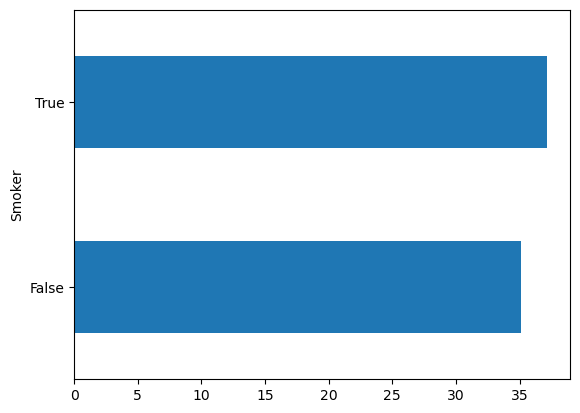

In [115]:
targetCorrelation(dataset, 'Smoker').plot.barh()

<Axes: ylabel='Cholesterol'>

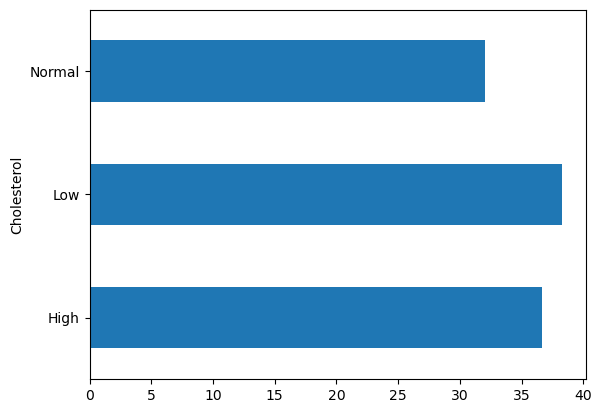

In [116]:
targetCorrelation(dataset, 'Cholesterol').plot.barh()

<Axes: ylabel='StressLevel'>

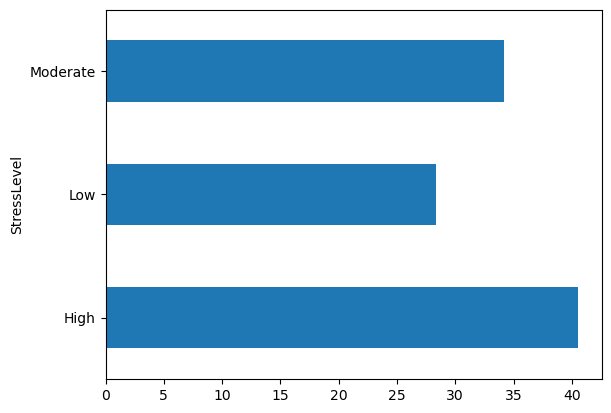

In [117]:
targetCorrelation(dataset, 'StressLevel').plot.barh()

<Axes: ylabel='Hypertension'>

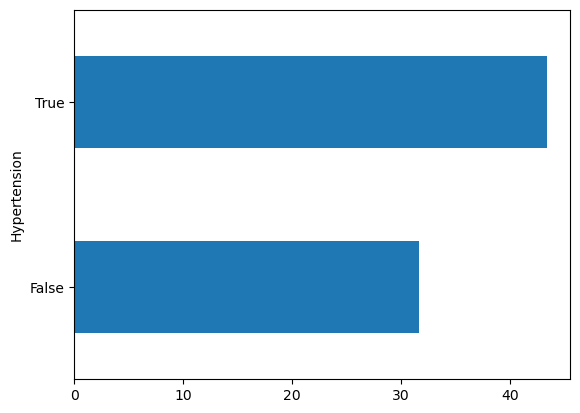

In [118]:
targetCorrelation(dataset, 'Hypertension').plot.barh()

<Axes: ylabel='PhysicalActivity'>

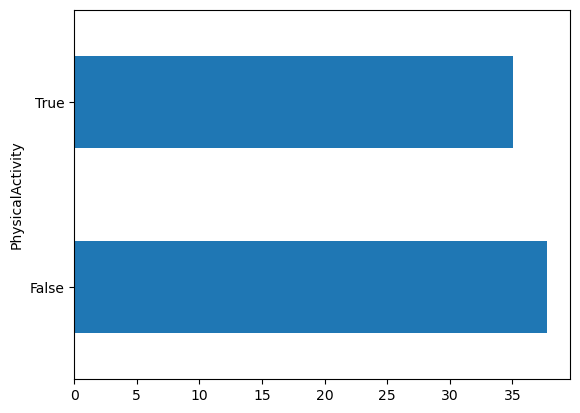

In [119]:
targetCorrelation(dataset, 'PhysicalActivity').plot.barh()

<Axes: ylabel='HealthyDiet'>

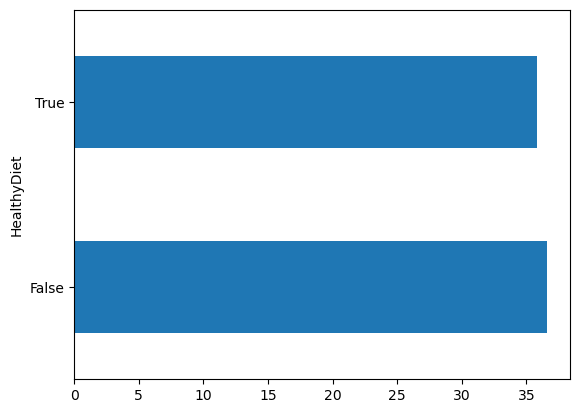

In [120]:
targetCorrelation(dataset, 'HealthyDiet').plot.barh()

<Axes: ylabel='IncomeLevel'>

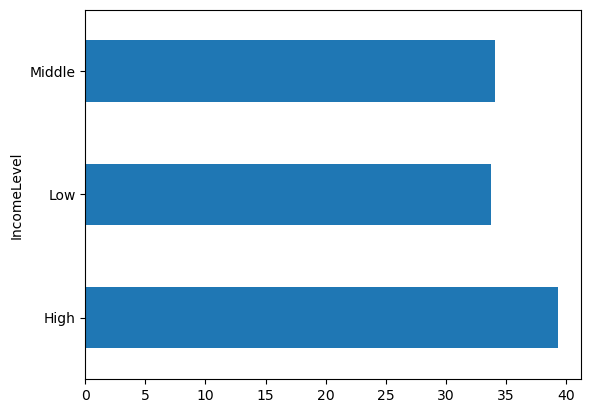

In [121]:
targetCorrelation(dataset, 'IncomeLevel').plot.barh()

<Axes: ylabel='FamilyHistory'>

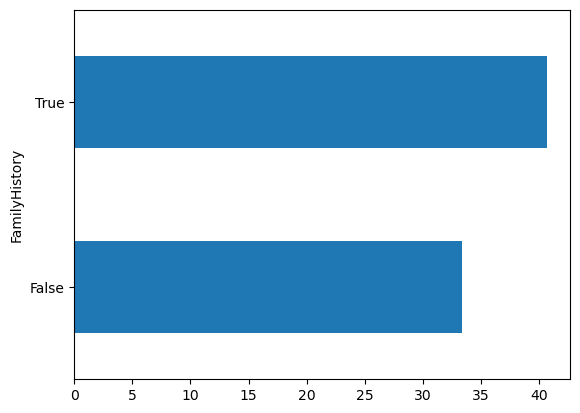

In [122]:
targetCorrelation(dataset, 'FamilyHistory').plot.barh()

<Axes: ylabel='PreviousHeartAttack'>

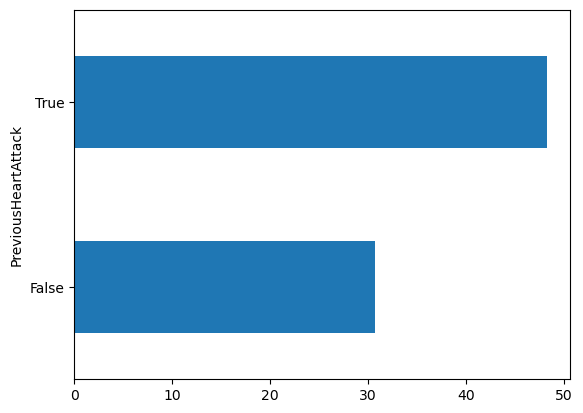

In [123]:
targetCorrelation(dataset, 'PreviousHeartAttack').plot.barh()

# LOGISTIC REGRESSION

In [124]:
# Setup

X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome'].astype(int)

numeric_features = ['Age', 'BloodPressure']
binary_features = ['Smoker', 'Hypertension', 'Diabetes', 'Obesity',
                   'PhysicalActivity', 'HealthyDiet', 'AlcoholConsumption',
                   'FamilyHistory', 'PreviousHeartAttack']
categorical_features = ['Gender', 'Cholesterol', 'StressLevel', 'IncomeLevel']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("="*60)
print("CLASSIFICAZIONE CON LOGISTIC REGRESSION + ELASTIC NET")
print("="*60 + "\n")

# Distribuzione classi
print(f"Distribuzione classi training:")
print(f"  No Outcome: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Outcome: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"  Ratio: {np.sum(y_train==0)/np.sum(y_train==1):.2f}:1\n")


CLASSIFICAZIONE CON LOGISTIC REGRESSION + ELASTIC NET

Distribuzione classi training:
  No Outcome: 398960 (63.9%)
  Outcome: 225516 (36.1%)
  Ratio: 1.77:1



In [125]:
# ========================================
# LOGISTIC REGRESSION CON ELASTIC NET
# ========================================
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=42,
        class_weight='balanced',  # gestisce lo sbilanciamento
        n_jobs=-1
    ))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

# Usa F1 score per bilanciare precision e recall
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',  # meglio di accuracy per classi sbilanciate
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Migliori parametri:")
print(f"  - C: {grid_search.best_params_['classifier__C']}")
print(f"  - L1 ratio: {grid_search.best_params_['classifier__l1_ratio']}")
print(f"  - F1 score CV: {grid_search.best_score_:.4f}\n")



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Migliori parametri:
  - C: 1.0
  - L1 ratio: 1.0
  - F1 score CV: 0.5458



In [126]:
# ========================================
# VALUTAZIONE
# ========================================
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

print("="*60)
print("METRICHE DI CLASSIFICAZIONE")
print("="*60 + "\n")

print("TRAINING SET:")
print(classification_report(y_train, y_pred_train, 
                          target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_train, y_pred_proba_train):.4f}\n")

print("TEST SET:")
print(classification_report(y_test, y_pred_test, 
                          target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}\n")


METRICHE DI CLASSIFICAZIONE

TRAINING SET:
              precision    recall  f1-score   support

  No Outcome       0.75      0.63      0.68    398960
     Outcome       0.49      0.62      0.55    225516

    accuracy                           0.63    624476
   macro avg       0.62      0.63      0.61    624476
weighted avg       0.65      0.63      0.63    624476

ROC-AUC: 0.6624

TEST SET:
              precision    recall  f1-score   support

  No Outcome       0.74      0.63      0.68     99740
     Outcome       0.49      0.62      0.54     56379

    accuracy                           0.63    156119
   macro avg       0.62      0.62      0.61    156119
weighted avg       0.65      0.63      0.63    156119

ROC-AUC: 0.6621



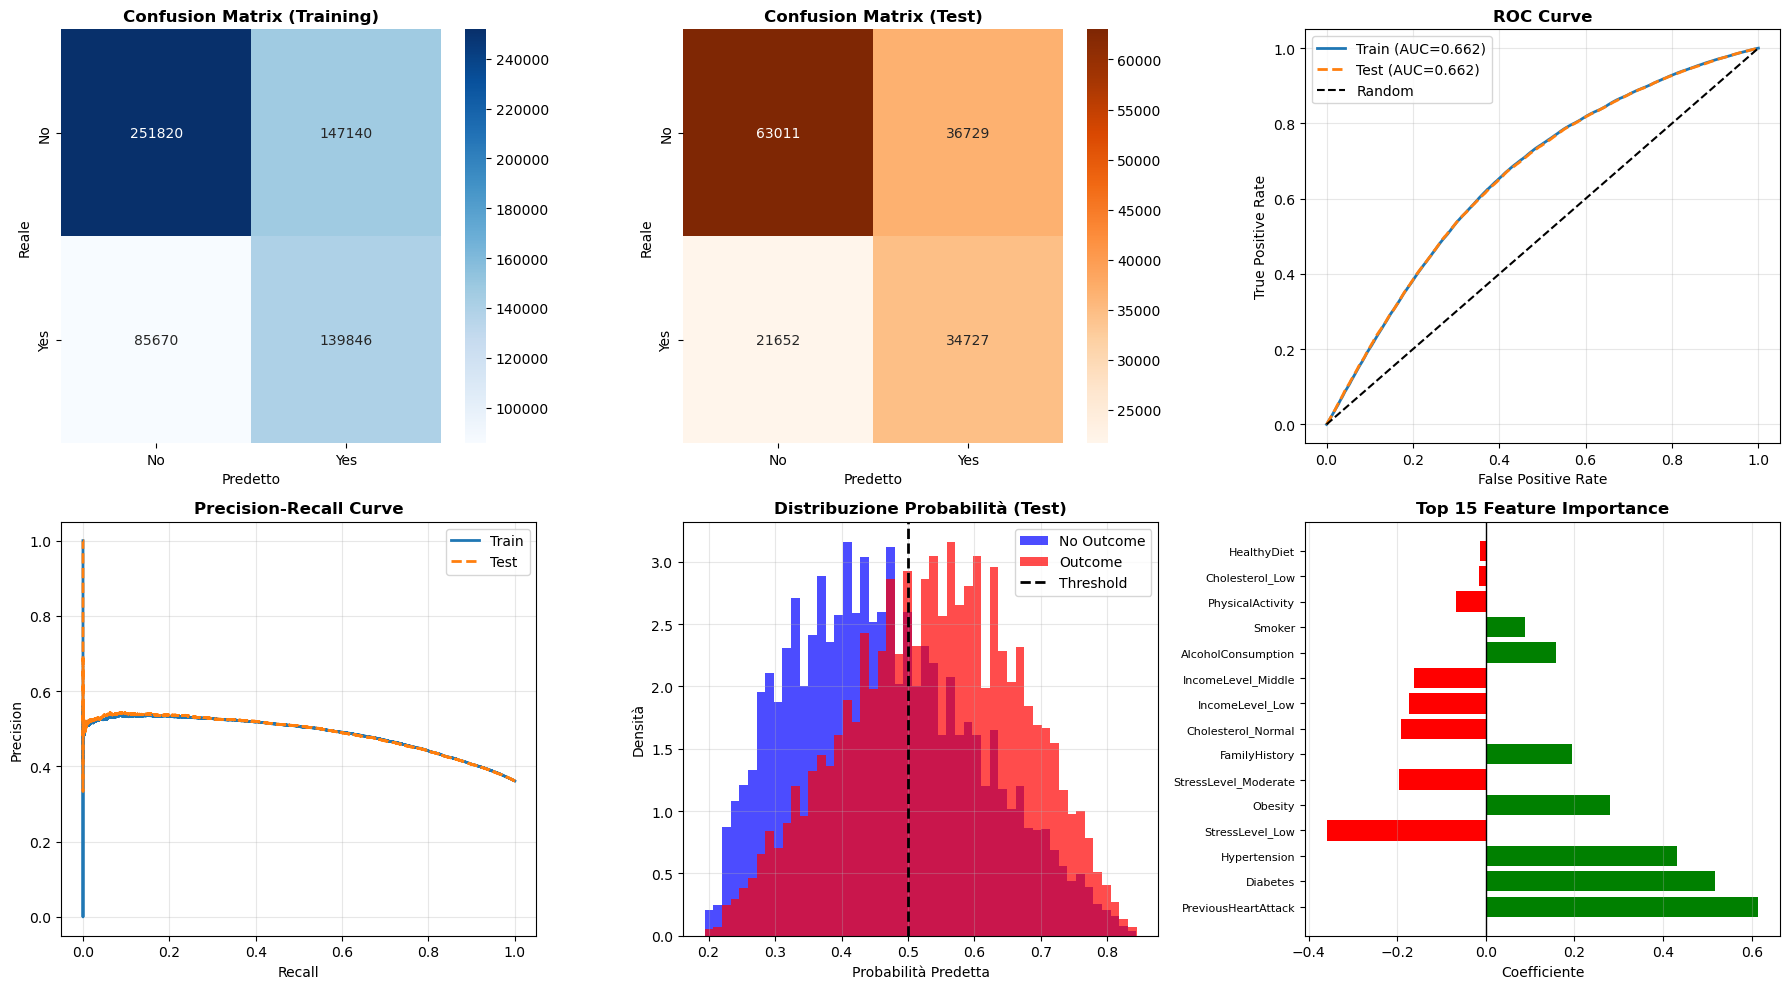


ANALISI THRESHOLD OTTIMALE

Threshold    Precision    Recall       F1          
------------------------------------------------
0.3          0.381        0.960        0.546       
0.4          0.426        0.840        0.566       
0.5          0.486        0.616        0.543       
0.6          0.525        0.340        0.412       
0.7          0.539        0.112        0.186       

 Abbassare il threshold (ex: 0.3-0.4) per aumentare il recall


In [127]:
# ========================================
# GRAFICI
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Confusion Matrix (Train)
cm_train = confusion_matrix(y_train, y_pred_train)
sb.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0, 0].set_xlabel('Predetto')
axes[0, 0].set_ylabel('Reale')
axes[0, 0].set_title('Confusion Matrix (Training)', fontweight='bold')

# 2. Confusion Matrix (Test)
cm_test = confusion_matrix(y_test, y_pred_test)
sb.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0, 1].set_xlabel('Predetto')
axes[0, 1].set_ylabel('Reale')
axes[0, 1].set_title('Confusion Matrix (Test)', fontweight='bold')

# 3. ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

axes[0, 2].plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_pred_proba_train):.3f})', 
                linewidth=2)
axes[0, 2].plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_pred_proba_test):.3f})', 
                linewidth=2, linestyle='--')
axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)

axes[1, 0].plot(recall_train, precision_train, label='Train', linewidth=2)
axes[1, 0].plot(recall_test, precision_test, label='Test', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribuzione probabilità predette
axes[1, 1].hist(y_pred_proba_test[y_test==0], bins=50, alpha=0.7, 
                label='No Outcome', color='blue', density=True)
axes[1, 1].hist(y_pred_proba_test[y_test==1], bins=50, alpha=0.7, 
                label='Outcome', color='red', density=True)
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 1].set_xlabel('Probabilità Predetta')
axes[1, 1].set_ylabel('Densità')
axes[1, 1].set_title('Distribuzione Probabilità (Test)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Feature Importance (coefficienti)
coefficients = best_model.named_steps['classifier'].coef_[0]

feature_names = []
feature_names.extend(numeric_features)
fitted_preprocessor = best_model.named_steps['preprocessor']
cat_features = fitted_preprocessor.named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)

feature_names.extend(cat_features)
feature_names.extend(binary_features)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False).head(15)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
axes[1, 2].barh(range(len(coef_df)), coef_df['Coefficient'], color=colors)
axes[1, 2].set_yticks(range(len(coef_df)))
axes[1, 2].set_yticklabels(coef_df['Feature'], fontsize=8)
axes[1, 2].set_xlabel('Coefficiente')
axes[1, 2].set_title('Top 15 Feature Importance', fontweight='bold')
axes[1, 2].axvline(0, color='black', linewidth=1)
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ========================================
# ANALISI THRESHOLD
# ========================================
print("\n" + "="*60)
print("ANALISI THRESHOLD OTTIMALE")
print("="*60 + "\n")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 48)

from sklearn.metrics import precision_score, recall_score, f1_score

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_test >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"{thresh:<12.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")

print("\n Abbassare il threshold (ex: 0.3-0.4) per aumentare il recall")

# XGBOOST

In [128]:
print("="*70)
print("XGBOOST CLASSIFIER")
print("="*70 + "\n")

# ========================================
# 1. PREPROCESSING PER XGBOOST
# ========================================
print("FASE 1: Preprocessing per XGBoost")
print("-"*70)

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # NO scaling per tree-based
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
         categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

# Split con validation set per early stopping
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class ratio (train): {(y_train==0).sum()/(y_train==1).sum():.2f}:1\n")

XGBOOST CLASSIFIER

FASE 1: Preprocessing per XGBoost
----------------------------------------------------------------------
Training set: 499580 samples
Validation set: 124896 samples
Test set: 156119 samples
Class ratio (train): 1.77:1



In [129]:
# ========================================
# 2. PIPELINE XGBOOST
# ========================================

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        tree_method='hist',  # più veloce
        n_jobs=-1
    ))
])

Scale pos weight: 1.77


In [130]:
# ========================================
# 3. GRID SEARCH LEGGERO (ma efficace)
# ========================================
print("FASE 3: Grid Search Leggero")
print("-"*70)

# VERSIONE LIGHT: 24 combinazioni invece di 144
param_grid_xgb_light = {
    'classifier__n_estimators': [200, 300],  # 2 valori invece di 3
    'classifier__max_depth': [4, 6],  # 2 valori invece di 4
    'classifier__learning_rate': [0.05, 0.1],  # 2 valori invece di 3
    'classifier__min_child_weight': [1, 3],  # mantieni
    'classifier__subsample': [0.8],  # fisso
    'classifier__colsample_bytree': [0.8],  # fisso
    'classifier__gamma': [0],  # fisso a 0 per velocità
}

# Calcolo combinazioni
n_combinations = (2 * 2 * 2 * 2 * 1 * 1 * 1)  # = 16
n_folds = 3  # riduco a 3 per velocità
total_fits = n_combinations * n_folds

print(f"Configurazione Grid Search:")
print(f"  - Combinazioni parametri: {n_combinations}")
print(f"  - Cross-validation folds: {n_folds}")
print(f"  - Totale modelli da addestrare: {total_fits}")
print(f"  - Tempo stimato: ~3-5 minuti\n")

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb_light,
    cv=3,  # 3 invece di 5 (più veloce)
    scoring='f1',
    n_jobs=-1,
    verbose=2,  # più verboso per monitorare progresso
    return_train_score=True
)

# Fit SENZA early stopping (più veloce)
grid_xgb.fit(X_train, y_train)

print(f"\nMigliori parametri:")
for param, value in grid_xgb.best_params_.items():
    print(f"  - {param.replace('classifier__', '')}: {value}")
print(f"\nMiglior F1 score (CV): {grid_xgb.best_score_:.4f}\n")

# Top 5 configurazioni
results_df = pd.DataFrame(grid_xgb.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("Top 5 configurazioni:")
print("-"*70)
cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 
        'param_classifier__max_depth', 'param_classifier__learning_rate', 
        'param_classifier__n_estimators']
print(results_df[cols].head(5).to_string(index=False))
print()

FASE 3: Grid Search Leggero
----------------------------------------------------------------------
Configurazione Grid Search:
  - Combinazioni parametri: 16
  - Cross-validation folds: 3
  - Totale modelli da addestrare: 48
  - Tempo stimato: ~3-5 minuti

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\miria\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:13:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Migliori parametri:
  - colsample_bytree: 0.8
  - gamma: 0
  - learning_rate: 0.05
  - max_depth: 6
  - min_child_weight: 1
  - n_estimators: 200
  - subsample: 0.8

Miglior F1 score (CV): 0.5703

Top 5 configurazioni:
----------------------------------------------------------------------
 rank_test_score  mean_test_score  std_test_score  param_classifier__max_depth  param_classifier__learning_rate  param_classifier__n_estimators
               1         0.570334        0.000757                            6                             0.05                             200
               2         0.570272        0.000750                            6                             0.05                             300
               3         0.570193        0.000785                            6                             0.05                             300
               4         0.570116        0.000864                            6                             0.05                      

In [131]:
# ========================================
# 4. VALUTAZIONE COMPLETA
# ========================================
print("\n" + "="*70)
print("FASE 4: Valutazione del Modello")
print("="*70 + "\n")

best_xgb = grid_xgb.best_estimator_

# Predizioni
y_pred_train = best_xgb.predict(X_train)
y_pred_val = best_xgb.predict(X_val)
y_pred_test = best_xgb.predict(X_test)

y_proba_train = best_xgb.predict_proba(X_train)[:, 1]
y_proba_val = best_xgb.predict_proba(X_val)[:, 1]
y_proba_test = best_xgb.predict_proba(X_test)[:, 1]

# Metriche per ogni set
for name, y_true, y_pred, y_proba in [
    ("TRAINING", y_train, y_pred_train, y_proba_train),
    ("VALIDATION", y_val, y_pred_val, y_proba_val),
    ("TEST", y_test, y_pred_test, y_proba_test)
]:
    print(f"{name} SET:")
    print("-"*70)
    print(classification_report(y_true, y_pred, 
                              target_names=['No Outcome', 'Outcome'],
                              digits=3))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"Recall Outcome: {recall_score(y_true, y_pred):.3f}")
    print(f"Precision Outcome: {precision_score(y_true, y_pred):.3f}")
    print(f"F1 Outcome: {f1_score(y_true, y_pred):.3f}\n")




FASE 4: Valutazione del Modello

TRAINING SET:
----------------------------------------------------------------------
              precision    recall  f1-score   support

  No Outcome      0.775     0.581     0.664    319167
     Outcome      0.487     0.702     0.575    180413

    accuracy                          0.625    499580
   macro avg      0.631     0.642     0.620    499580
weighted avg      0.671     0.625     0.632    499580

ROC-AUC: 0.689
Recall Outcome: 0.702
Precision Outcome: 0.487
F1 Outcome: 0.575

VALIDATION SET:
----------------------------------------------------------------------
              precision    recall  f1-score   support

  No Outcome      0.770     0.579     0.661     79793
     Outcome      0.483     0.695     0.570     45103

    accuracy                          0.621    124896
   macro avg      0.627     0.637     0.615    124896
weighted avg      0.667     0.621     0.628    124896

ROC-AUC: 0.682
Recall Outcome: 0.695
Precision Outcome: 0.4

In [132]:
# ========================================
# 5. FEATURE IMPORTANCE (XGBOOST)
# ========================================
print("="*70)
print("FASE 5: Feature Importance")
print("="*70 + "\n")

fitted_preprocessor = best_xgb.named_steps['preprocessor']

# Ottieni feature names dopo preprocessing
feature_names = []
feature_names.extend(numeric_features)
cat_features = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names.extend(cat_features)
feature_names.extend(binary_features)

# XGBoost feature importance (3 tipi)
importance_weight = best_xgb.named_steps['classifier'].feature_importances_
importance_gain = best_xgb.named_steps['classifier'].get_booster().get_score(importance_type='gain')
importance_cover = best_xgb.named_steps['classifier'].get_booster().get_score(importance_type='cover')

# Converti dict in array (gain e cover usano nomi tipo f0, f1, ...)
importance_gain_array = np.array([importance_gain.get(f'f{i}', 0) for i in range(len(feature_names))])
importance_cover_array = np.array([importance_cover.get(f'f{i}', 0) for i in range(len(feature_names))])

# DataFrame completo
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': importance_weight,
    'Gain': importance_gain_array,
    'Cover': importance_cover_array
}).sort_values('Gain', ascending=False)

print("Top 15 Feature (ordinato per Gain):")
print("-"*70)
print(importance_df.head(15).to_string(index=False))
print()

FASE 5: Feature Importance

Top 15 Feature (ordinato per Gain):
----------------------------------------------------------------------
             Feature   Weight       Gain        Cover
 PreviousHeartAttack 0.313132 409.529816 30016.382812
            Diabetes 0.153738 201.066757 19716.046875
        Hypertension 0.127312 166.505463 15975.341797
             Obesity 0.076150  99.593391 18391.056641
     StressLevel_Low 0.058486  76.490555 14476.125000
       FamilyHistory 0.047964  62.730091  9941.715820
  AlcoholConsumption 0.045792  59.888893 11077.674805
StressLevel_Moderate 0.036398  47.603092 13573.555664
     Cholesterol_Low 0.024142  31.574541  9231.875977
  Cholesterol_Normal 0.022615  29.577034 15325.765625
  IncomeLevel_Middle 0.019314  25.260427 10669.720703
                 Age 0.017039  22.284389 10924.378906
     IncomeLevel_Low 0.016178  21.158253 12021.809570
              Smoker 0.014739  19.276886  8334.085938
    PhysicalActivity 0.009397  12.290240 11215.752930



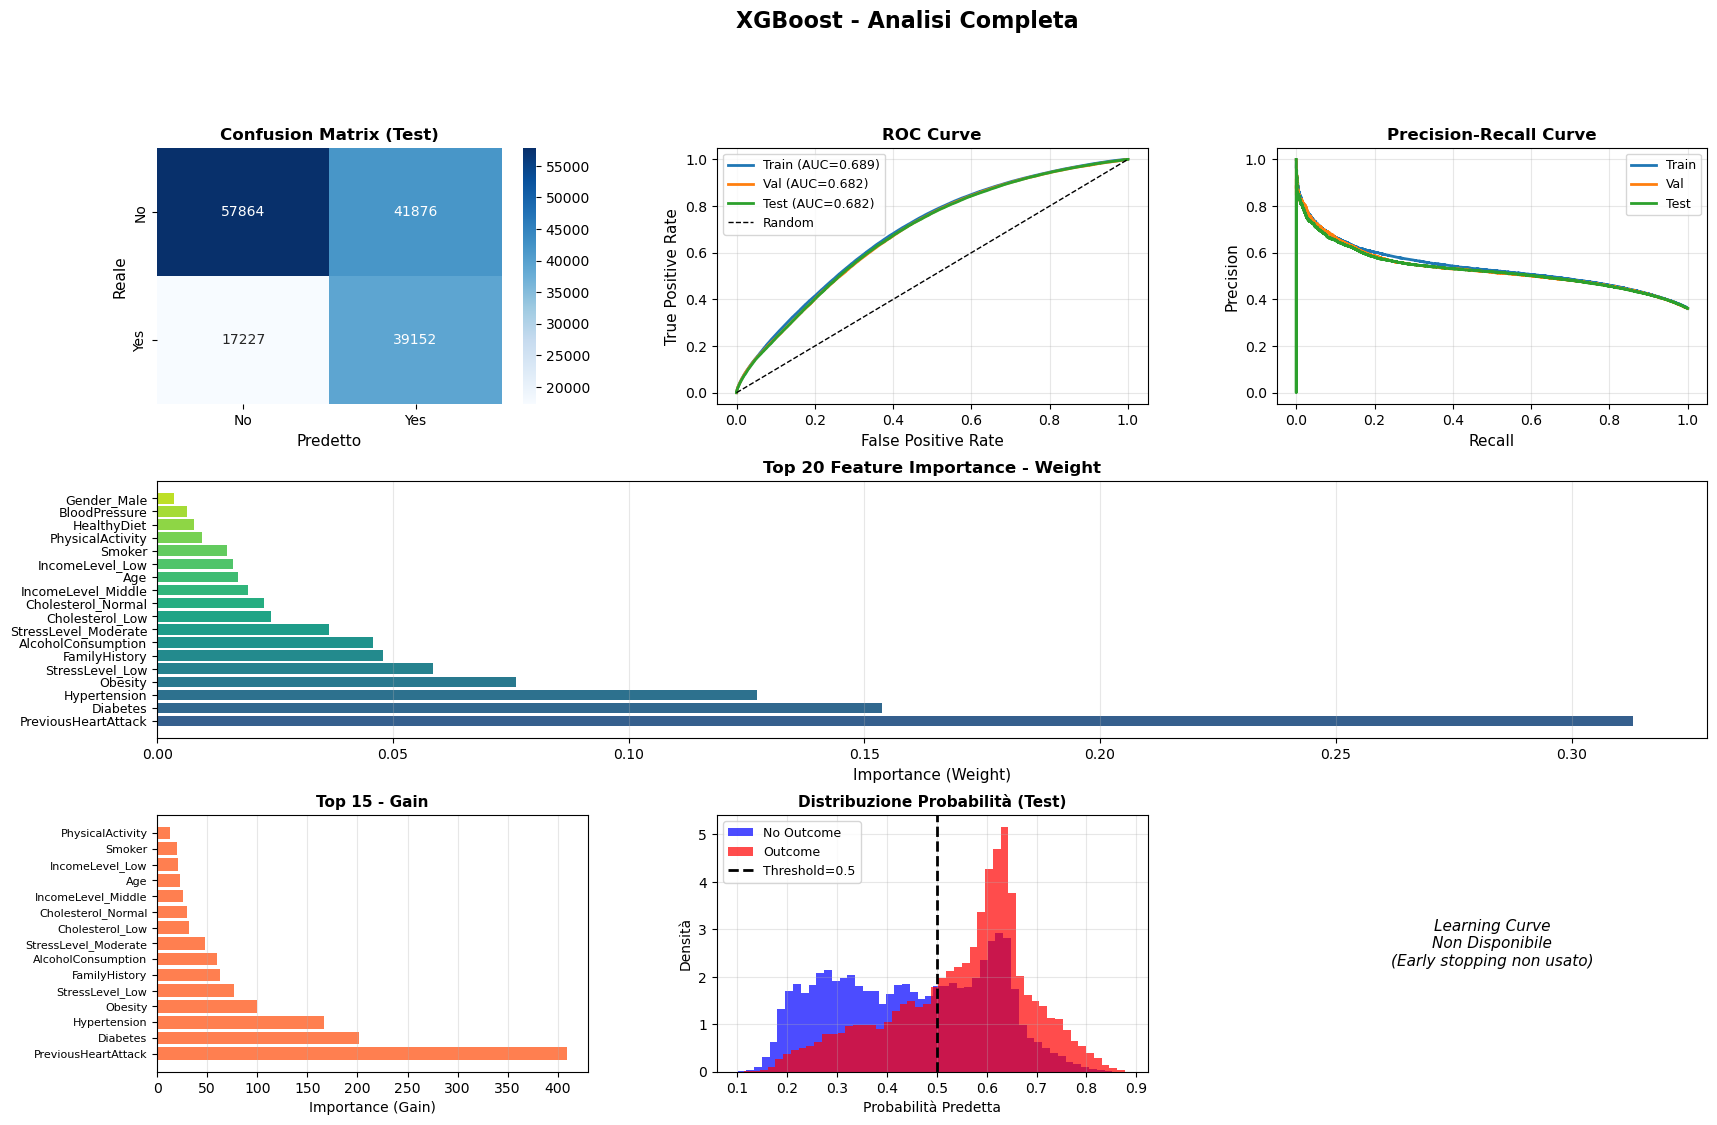

In [133]:
# ========================================
# 6. VISUALIZZAZIONI COMPLETE
# ========================================
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix (Test)
ax1 = fig.add_subplot(gs[0, 0])
cm_test = confusion_matrix(y_test, y_pred_test)
sb.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax1.set_xlabel('Predetto', fontsize=11)
ax1.set_ylabel('Reale', fontsize=11)
ax1.set_title('Confusion Matrix (Test)', fontsize=12, fontweight='bold')

# 2. ROC Curve (confronto Train/Val/Test)
ax2 = fig.add_subplot(gs[0, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

ax2.plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_proba_train):.3f})', linewidth=2)
ax2.plot(fpr_val, tpr_val, label=f'Val (AUC={roc_auc_score(y_val, y_proba_val):.3f})', linewidth=2)
ax2.plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_proba_test):.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
prec_train, rec_train, _ = precision_recall_curve(y_train, y_proba_train)
prec_val, rec_val, _ = precision_recall_curve(y_val, y_proba_val)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_proba_test)

ax3.plot(rec_train, prec_train, label='Train', linewidth=2)
ax3.plot(rec_val, prec_val, label='Val', linewidth=2)
ax3.plot(rec_test, prec_test, label='Test', linewidth=2)
ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Weight)
ax4 = fig.add_subplot(gs[1, :])
top_20 = importance_df.head(20)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
ax4.barh(range(len(top_20)), top_20['Weight'], color=colors)
ax4.set_yticks(range(len(top_20)))
ax4.set_yticklabels(top_20['Feature'], fontsize=9)
ax4.set_xlabel('Importance (Weight)', fontsize=11)
ax4.set_title('Top 20 Feature Importance - Weight', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Feature Importance (Gain)
ax5 = fig.add_subplot(gs[2, 0])
top_15_gain = importance_df.nlargest(15, 'Gain')
ax5.barh(range(len(top_15_gain)), top_15_gain['Gain'], color='coral')
ax5.set_yticks(range(len(top_15_gain)))
ax5.set_yticklabels(top_15_gain['Feature'], fontsize=8)
ax5.set_xlabel('Importance (Gain)', fontsize=10)
ax5.set_title('Top 15 - Gain', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6. Distribuzione Probabilità
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_proba_test[y_test==0], bins=50, alpha=0.7, label='No Outcome', 
         color='blue', density=True)
ax6.hist(y_proba_test[y_test==1], bins=50, alpha=0.7, label='Outcome', 
         color='red', density=True)
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
ax6.set_xlabel('Probabilità Predetta', fontsize=10)
ax6.set_ylabel('Densità', fontsize=10)
ax6.set_title('Distribuzione Probabilità (Test)', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# 7. Learning Curve (se disponibile)
# 7. Learning Curve (se disponibile) - VERSIONE CORRETTA
ax7 = fig.add_subplot(gs[2, 2])

# ✅ Controlla se evals_result è disponibile PRIMA di chiamarlo
try:
    evals_result = best_xgb.named_steps['classifier'].evals_result()
    
    # Se arriviamo qui, evals_result esiste
    if evals_result and 'validation_0' in evals_result:
        epochs = len(evals_result['validation_0']['logloss'])
        x_axis = range(0, epochs)
        ax7.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation', linewidth=2)
        ax7.set_xlabel('Iterations', fontsize=10)
        ax7.set_ylabel('Log Loss', fontsize=10)
        ax7.set_title('Learning Curve', fontsize=11, fontweight='bold')
        ax7.legend(fontsize=9)
        ax7.grid(True, alpha=0.3)
    else:
        # evals_result esiste ma è vuoto
        ax7.text(0.5, 0.5, 'Learning Curve\nNon Disponibile\n(Early stopping non usato)', 
                 ha='center', va='center', fontsize=11, style='italic')
        ax7.axis('off')
        
except Exception:
    # evals_result non esiste (nessun eval_set durante training)
    ax7.text(0.5, 0.5, 'Learning Curve\nNon Disponibile\n(Early stopping non usato)', 
             ha='center', va='center', fontsize=11, style='italic')
    ax7.axis('off')

plt.suptitle('XGBoost - Analisi Completa', fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [134]:
# ========================================
# 7. ANALISI THRESHOLD
# ========================================
print("="*70)
print("FASE 7: Analisi Threshold Ottimale")
print("="*70 + "\n")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<12}")
print("-"*60)

for thresh in thresholds:
    y_pred_thresh = (y_proba_test >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    support = np.sum(y_pred_thresh)
    print(f"{thresh:<12.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {support:<12}")

print("\n Abbassare il threshold per aumentare recall (trovare più casi positivi)")
print("Alzare il threshold per aumentare precision (essere più sicuri)\n")

FASE 7: Analisi Threshold Ottimale

Threshold    Precision    Recall       F1           Support     
------------------------------------------------------------
0.3          0.407        0.930        0.566        128824      
0.4          0.445        0.836        0.581        105843      
0.5          0.483        0.694        0.570        81028       
0.6          0.525        0.448        0.483        48106       
0.7          0.643        0.111        0.190        9758        

 Abbassare il threshold per aumentare recall (trovare più casi positivi)
Alzare il threshold per aumentare precision (essere più sicuri)



CONFRONTO COMPLETO: LOGISTIC REGRESSION vs XGBOOST

FASE 1: Raccolta predizioni dai modelli
--------------------------------------------------------------------------------
✓ Predizioni raccolte per entrambi i modelli

FASE 2: Metriche Comparative

TABELLA COMPARATIVA COMPLETA:
--------------------------------------------------------------------------------
               Metrica  LR (Train)  LR (Test)  XGB (Train)  XGB (Test)  Δ (Test) Winner
              Accuracy      0.6270     0.6260       0.6249      0.6214   -0.0046    Tie
   Precision (Outcome)      0.4871     0.4860       0.4865      0.4832   -0.0028    Tie
      Recall (Outcome)      0.6207     0.6160       0.7016      0.6944    0.0785    XGB
          F1 (Outcome)      0.5458     0.5433       0.5746      0.5699    0.0266    XGB
               ROC-AUC      0.6626     0.6621       0.6894      0.6824    0.0203    XGB
                   MCC      0.2422     0.2388       0.2722      0.2640    0.0252    XGB
Precision (No Outcome)  

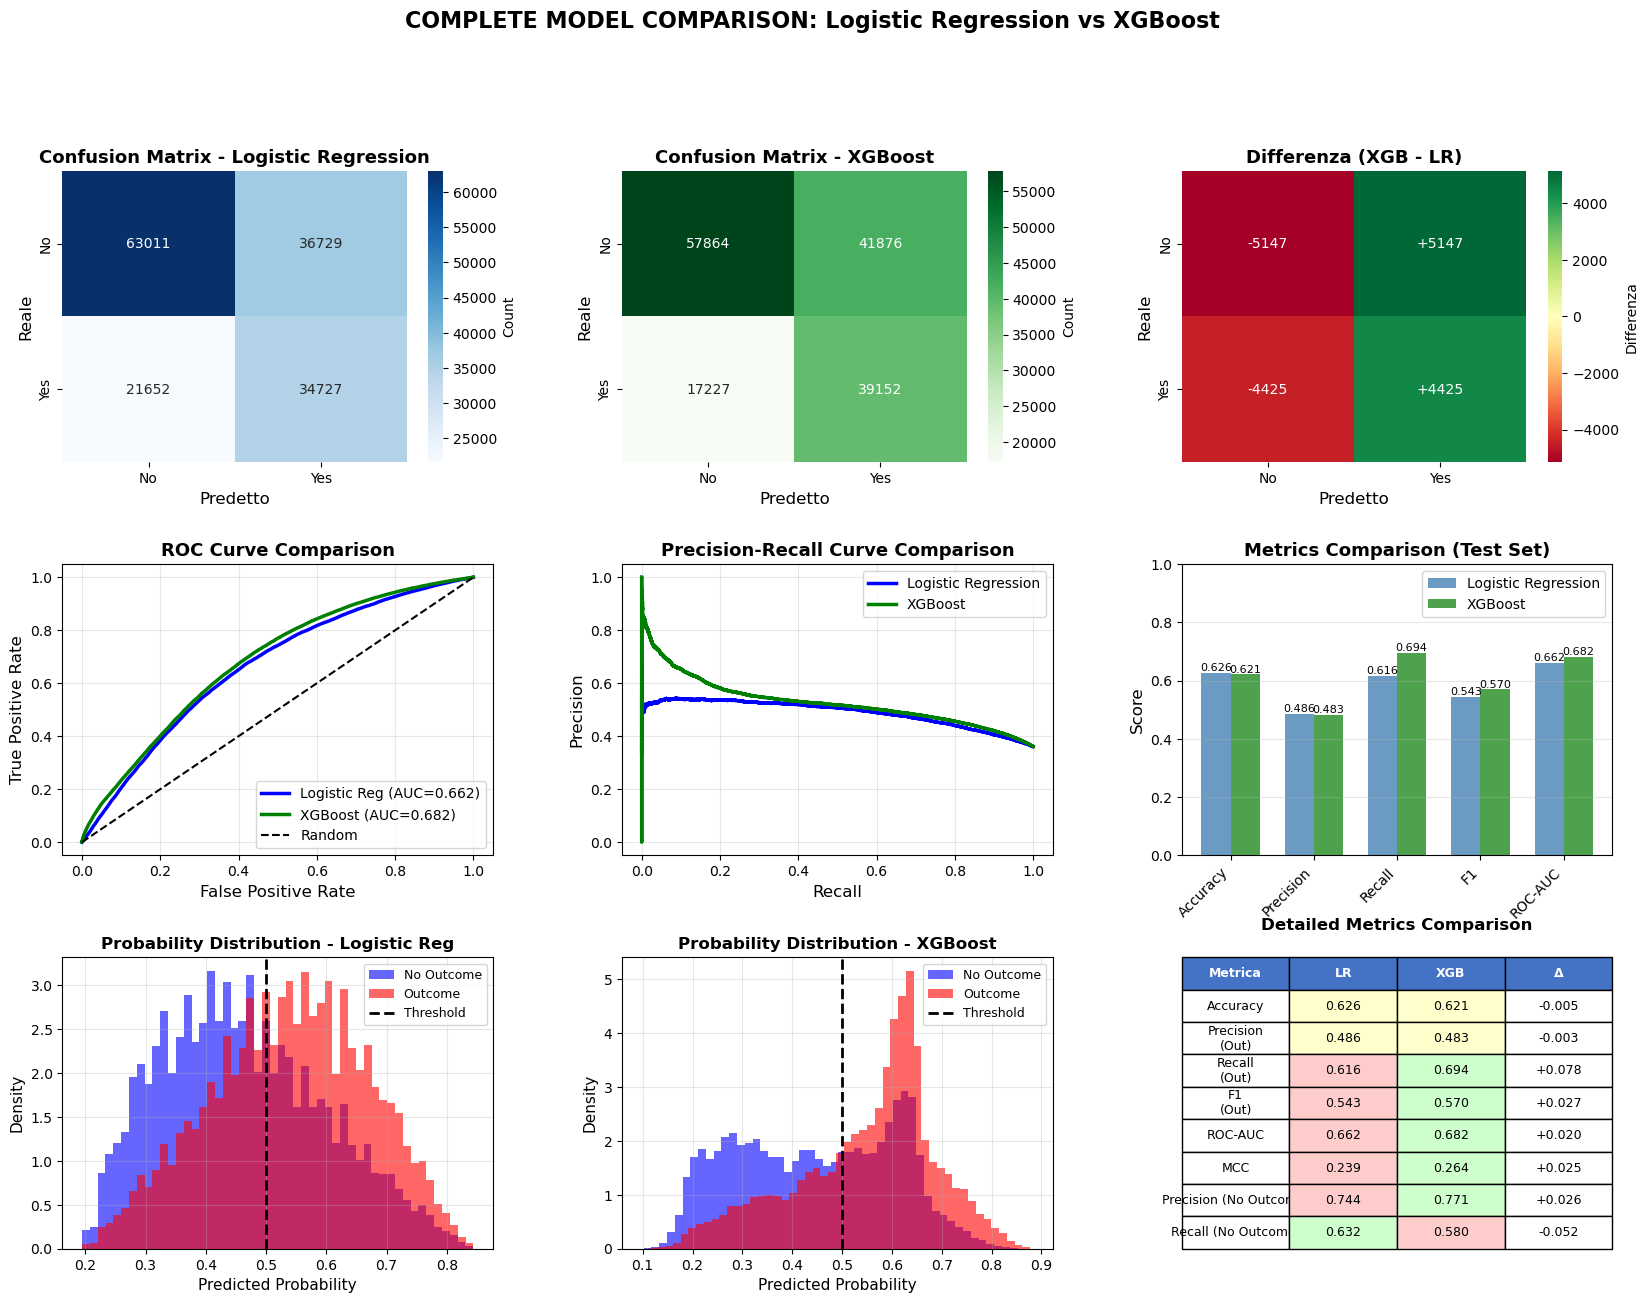

✓ Visualizzazioni generate

FASE 6: Analisi degli Errori

ANALISI ERRORI:
--------------------------------------------------------------------------------
Entrambi corretti:           89130 (57.09%)
Entrambi sbagliati:          50495 (32.34%)
Solo LR sbagliato:            7886 ( 5.05%)
Solo XGB sbagliato:           8608 ( 5.51%)

SOVRAPPOSIZIONE ERRORI:
--------------------------------------------------------------------------------
Accordo nelle predizioni: 89.43%
Disaccordo:               10.57%

FASE 7: Analisi Threshold per Entrambi i Modelli

LOGISTIC REGRESSION:
--------------------------------------------------------------------------------
Thresh   Precision    Recall       F1           Predicted+  
--------------------------------------------------------
0.3      0.381        0.960        0.546        141863      
0.4      0.426        0.840        0.566        111175      
0.5      0.486        0.616        0.543        71456       
0.6      0.525        0.340        0.412   

In [ ]:
print("="*80)
print("CONFRONTO COMPLETO: LOGISTIC REGRESSION vs XGBOOST")
print("="*80 + "\n")

# ========================================
# 1. RACCOLTA PREDIZIONI
# ========================================
print("FASE 1: Raccolta predizioni dai modelli")
print("-"*80)

# Assicurati di avere le predizioni di entrambi i modelli
# Logistic Regression
y_pred_train_lr = best_model.predict(X_train)  # best_model è il LogisticRegression
y_pred_test_lr = best_model.predict(X_test)
y_proba_train_lr = best_model.predict_proba(X_train)[:, 1]
y_proba_test_lr = best_model.predict_proba(X_test)[:, 1]

# XGBoost
y_pred_train_xgb = best_xgb.predict(X_train)
y_pred_test_xgb = best_xgb.predict(X_test)
y_proba_train_xgb = best_xgb.predict_proba(X_train)[:, 1]
y_proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("✓ Predizioni raccolte per entrambi i modelli\n")

# ========================================
# 2. TABELLA COMPARATIVA METRICHE
# ========================================
print("="*80)
print("FASE 2: Metriche Comparative")
print("="*80 + "\n")

def calculate_all_metrics(y_true, y_pred, y_proba):
    """Calcola tutte le metriche di interesse"""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Outcome)': precision_score(y_true, y_pred),
        'Recall (Outcome)': recall_score(y_true, y_pred),
        'F1 (Outcome)': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'MCC': matthews_corrcoef(y_true, y_pred),  # Matthews Correlation Coefficient
        'Precision (No Outcome)': precision_score(y_true, y_pred, pos_label=0),
        'Recall (No Outcome)': recall_score(y_true, y_pred, pos_label=0),
    }

# Calcola metriche per entrambi i modelli
metrics_train_lr = calculate_all_metrics(y_train, y_pred_train_lr, y_proba_train_lr)
metrics_test_lr = calculate_all_metrics(y_test, y_pred_test_lr, y_proba_test_lr)
metrics_train_xgb = calculate_all_metrics(y_train, y_pred_train_xgb, y_proba_train_xgb)
metrics_test_xgb = calculate_all_metrics(y_test, y_pred_test_xgb, y_proba_test_xgb)

# Crea DataFrame comparativo
comparison_df = pd.DataFrame({
    'Metrica': list(metrics_test_lr.keys()),
    'LR (Train)': list(metrics_train_lr.values()),
    'LR (Test)': list(metrics_test_lr.values()),
    'XGB (Train)': list(metrics_train_xgb.values()),
    'XGB (Test)': list(metrics_test_xgb.values()),
})

# Calcola differenze
comparison_df['Δ (Test)'] = comparison_df['XGB (Test)'] - comparison_df['LR (Test)']
comparison_df['Winner'] = comparison_df['Δ (Test)'].apply(
    lambda x: 'XGB' if x > 0.01 else ('LR' if x < -0.01 else 'Tie')
)

print("TABELLA COMPARATIVA COMPLETA:")
print("-"*80)
print(comparison_df.to_string(index=False, float_format='%.4f'))
print()

# Riassunto vincitori
print("\nRIASSUNTO:")
print("-"*80)
winner_counts = comparison_df['Winner'].value_counts()
for winner, count in winner_counts.items():
    print(f"  {winner}: {count} metriche")

# Identifica il vincitore generale
if winner_counts.get('XGB', 0) > winner_counts.get('LR', 0):
    overall_winner = "XGBoost"
elif winner_counts.get('LR', 0) > winner_counts.get('XGB', 0):
    overall_winner = "Logistic Regression"
else:
    overall_winner = "Pareggio"

print(f"\nVincitore generale (Test Set): {overall_winner}\n")

# ========================================
# 3. CLASSIFICATION REPORTS AFFIANCATI
# ========================================
print("="*80)
print("FASE 3: Classification Reports Dettagliati")
print("="*80 + "\n")

print("LOGISTIC REGRESSION - TEST SET:")
print("-"*80)
print(classification_report(y_test, y_pred_test_lr, 
                          target_names=['No Outcome', 'Outcome'],
                          digits=4))

print("\nXGBOOST - TEST SET:")
print("-"*80)
print(classification_report(y_test, y_pred_test_xgb, 
                          target_names=['No Outcome', 'Outcome'],
                          digits=4))

# ========================================
# 4. CONFUSION MATRICES COMPARATIVE
# ========================================
print("\n" + "="*80)
print("FASE 4: Confusion Matrices")
print("="*80 + "\n")

cm_lr = confusion_matrix(y_test, y_pred_test_lr)
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)

print("LOGISTIC REGRESSION:")
print(f"  True Negatives:  {cm_lr[0,0]:>8}")
print(f"  False Positives: {cm_lr[0,1]:>8}")
print(f"  False Negatives: {cm_lr[1,0]:>8}")
print(f"  True Positives:  {cm_lr[1,1]:>8}")

print("\nXGBOOST:")
print(f"  True Negatives:  {cm_xgb[0,0]:>8}")
print(f"  False Positives: {cm_xgb[0,1]:>8}")
print(f"  False Negatives: {cm_xgb[1,0]:>8}")
print(f"  True Positives:  {cm_xgb[1,1]:>8}")

print("\nDIFFERENZE (XGB - LR):")
print(f"  True Negatives:  {cm_xgb[0,0] - cm_lr[0,0]:>+8}")
print(f"  False Positives: {cm_xgb[0,1] - cm_lr[0,1]:>+8}")
print(f"  False Negatives: {cm_xgb[1,0] - cm_lr[1,0]:>+8}")
print(f"  True Positives:  {cm_xgb[1,1] - cm_lr[1,1]:>+8}")
print()

# ========================================
# 5. VISUALIZZAZIONI COMPARATIVE
# ========================================
print("="*80)
print("FASE 5: Visualizzazioni Comparative")
print("="*80 + "\n")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# === ROW 1: CONFUSION MATRICES ===

# 1. Confusion Matrix - Logistic Regression
ax1 = fig.add_subplot(gs[0, 0])
sb.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predetto', fontsize=12)
ax1.set_ylabel('Reale', fontsize=12)
ax1.set_title('Confusion Matrix - Logistic Regression', fontsize=13, fontweight='bold')

# 2. Confusion Matrix - XGBoost
ax2 = fig.add_subplot(gs[0, 1])
sb.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'})
ax2.set_xlabel('Predetto', fontsize=12)
ax2.set_ylabel('Reale', fontsize=12)
ax2.set_title('Confusion Matrix - XGBoost', fontsize=13, fontweight='bold')

# 3. Difference Heatmap
ax3 = fig.add_subplot(gs[0, 2])
diff_cm = cm_xgb - cm_lr
sb.heatmap(diff_cm, annot=True, fmt='+d', cmap='RdYlGn', center=0, ax=ax3,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Differenza'})
ax3.set_xlabel('Predetto', fontsize=12)
ax3.set_ylabel('Reale', fontsize=12)
ax3.set_title('Differenza (XGB - LR)', fontsize=13, fontweight='bold')

# === ROW 2: ROC & PRECISION-RECALL CURVES ===

# 4. ROC Curves Comparison
ax4 = fig.add_subplot(gs[1, 0])
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_test_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_test_xgb)

ax4.plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={roc_auc_score(y_test, y_proba_test_lr):.3f})', 
         linewidth=2.5, color='blue')
ax4.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_proba_test_xgb):.3f})', 
         linewidth=2.5, color='green')
ax4.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curve Comparison', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10, loc='lower right')
ax4.grid(True, alpha=0.3)

# 5. Precision-Recall Curves Comparison
ax5 = fig.add_subplot(gs[1, 1])
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_test_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_test_xgb)

ax5.plot(rec_lr, prec_lr, label='Logistic Regression', linewidth=2.5, color='blue')
ax5.plot(rec_xgb, prec_xgb, label='XGBoost', linewidth=2.5, color='green')
ax5.set_xlabel('Recall', fontsize=12)
ax5.set_ylabel('Precision', fontsize=12)
ax5.set_title('Precision-Recall Curve Comparison', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Metrics Bar Chart
ax6 = fig.add_subplot(gs[1, 2])
metrics_to_plot = ['Accuracy', 'Precision (Outcome)', 'Recall (Outcome)', 'F1 (Outcome)', 'ROC-AUC']
lr_values = [metrics_test_lr[m] for m in metrics_to_plot]
xgb_values = [metrics_test_xgb[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

bars1 = ax6.bar(x - width/2, lr_values, width, label='Logistic Regression', color='steelblue', alpha=0.8)
bars2 = ax6.bar(x + width/2, xgb_values, width, label='XGBoost', color='forestgreen', alpha=0.8)

ax6.set_ylabel('Score', fontsize=12)
ax6.set_title('Metrics Comparison (Test Set)', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels([m.replace(' (Outcome)', '') for m in metrics_to_plot], rotation=45, ha='right', fontsize=10)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim([0, 1])

# Aggiungi valori sopra le barre
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# === ROW 3: PROBABILITY DISTRIBUTIONS & METRICS TABLE ===

# 7. Probability Distribution - Logistic Regression
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(y_proba_test_lr[y_test==0], bins=50, alpha=0.6, label='No Outcome', 
         color='blue', density=True)
ax7.hist(y_proba_test_lr[y_test==1], bins=50, alpha=0.6, label='Outcome', 
         color='red', density=True)
ax7.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax7.set_xlabel('Predicted Probability', fontsize=11)
ax7.set_ylabel('Density', fontsize=11)
ax7.set_title('Probability Distribution - Logistic Reg', fontsize=12, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# 8. Probability Distribution - XGBoost
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(y_proba_test_xgb[y_test==0], bins=50, alpha=0.6, label='No Outcome', 
         color='blue', density=True)
ax8.hist(y_proba_test_xgb[y_test==1], bins=50, alpha=0.6, label='Outcome', 
         color='red', density=True)
ax8.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax8.set_xlabel('Predicted Probability', fontsize=11)
ax8.set_ylabel('Density', fontsize=11)
ax8.set_title('Probability Distribution - XGBoost', fontsize=12, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# 9. Metrics Difference Table
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('tight')
ax9.axis('off')

# Prepara dati per la tabella
table_data = []
for idx, row in comparison_df.iterrows():
    metric = row['Metrica'].replace(' (Outcome)', '\n(Out)')
    lr_val = f"{row['LR (Test)']:.3f}"
    xgb_val = f"{row['XGB (Test)']:.3f}"
    diff = f"{row['Δ (Test)']:+.3f}"
    winner = row['Winner']
    
    # Colore in base al vincitore
    if winner == 'XGB':
        color_lr = '#ffcccc'
        color_xgb = '#ccffcc'
    elif winner == 'LR':
        color_lr = '#ccffcc'
        color_xgb = '#ffcccc'
    else:
        color_lr = '#ffffcc'
        color_xgb = '#ffffcc'
    
    table_data.append([metric, lr_val, xgb_val, diff])

table = ax9.table(cellText=table_data,
                 colLabels=['Metrica', 'LR', 'XGB', 'Δ'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Colora le celle
for i in range(1, len(table_data) + 1):
    winner = comparison_df.iloc[i-1]['Winner']
    if winner == 'XGB':
        table[(i, 1)].set_facecolor('#ffcccc')
        table[(i, 2)].set_facecolor('#ccffcc')
    elif winner == 'LR':
        table[(i, 1)].set_facecolor('#ccffcc')
        table[(i, 2)].set_facecolor('#ffcccc')
    else:
        table[(i, 1)].set_facecolor('#ffffcc')
        table[(i, 2)].set_facecolor('#ffffcc')

# Header in grassetto
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax9.set_title('Detailed Metrics Comparison', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('COMPLETE MODEL COMPARISON: Logistic Regression vs XGBoost', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("Visualizzazioni generate\n")

# ========================================
# 6. ANALISI DEGLI ERRORI
# ========================================
print("="*80)
print("FASE 6: Analisi degli Errori")
print("="*80 + "\n")

# Trova dove i modelli sbagliano
lr_errors = y_test != y_pred_test_lr
xgb_errors = y_test != y_pred_test_xgb

# Errori comuni e unici
both_wrong = lr_errors & xgb_errors
only_lr_wrong = lr_errors & ~xgb_errors
only_xgb_wrong = ~lr_errors & xgb_errors
both_correct = ~lr_errors & ~xgb_errors

print("ANALISI ERRORI:")
print("-"*80)
print(f"Entrambi corretti:        {np.sum(both_correct):>8} ({np.sum(both_correct)/len(y_test)*100:>5.2f}%)")
print(f"Entrambi sbagliati:       {np.sum(both_wrong):>8} ({np.sum(both_wrong)/len(y_test)*100:>5.2f}%)")
print(f"Solo LR sbagliato:        {np.sum(only_lr_wrong):>8} ({np.sum(only_lr_wrong)/len(y_test)*100:>5.2f}%)")
print(f"Solo XGB sbagliato:       {np.sum(only_xgb_wrong):>8} ({np.sum(only_xgb_wrong)/len(y_test)*100:>5.2f}%)")
print()

# Venn Diagram dei dati
print("SOVRAPPOSIZIONE ERRORI:")
print("-"*80)
agreement = np.sum(y_pred_test_lr == y_pred_test_xgb) / len(y_test) * 100
print(f"Accordo nelle predizioni: {agreement:.2f}%")
print(f"Disaccordo:               {100-agreement:.2f}%")
print()

# ========================================
# 7. ANALISI THRESHOLD OTTIMALE
# ========================================
print("="*80)
print("FASE 7: Analisi Threshold per Entrambi i Modelli")
print("="*80 + "\n")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print("LOGISTIC REGRESSION:")
print("-"*80)
print(f"{'Thresh':<8} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Predicted+':<12}")
print("-"*56)
for thresh in thresholds:
    y_pred_thresh = (y_proba_test_lr >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    n_pos = np.sum(y_pred_thresh)
    print(f"{thresh:<8.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {n_pos:<12}")

print("\nXGBOOST:")
print("-"*80)
print(f"{'Thresh':<8} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Predicted+':<12}")
print("-"*56)
for thresh in thresholds:
    y_pred_thresh = (y_proba_test_xgb >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    n_pos = np.sum(y_pred_thresh)
    print(f"{thresh:<8.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {n_pos:<12}")

print()


print("\n" + "="*80)
print("RISULTATI CONFRONTO:")
print("="*80)
print(f"\nVincitore: {overall_winner}")
print(f"Differenza media metriche: {comparison_df['Δ (Test)'].abs().mean():.4f}")
print(f"Miglior ROC-AUC: {'XGBoost' if metrics_test_xgb['ROC-AUC'] > metrics_test_lr['ROC-AUC'] else 'Logistic Regression'} "
      f"({max(metrics_test_xgb['ROC-AUC'], metrics_test_lr['ROC-AUC']):.4f})")
print(f"Miglior F1: {'XGBoost' if metrics_test_xgb['F1 (Outcome)'] > metrics_test_lr['F1 (Outcome)'] else 'Logistic Regression'} "
      f"({max(metrics_test_xgb['F1 (Outcome)'], metrics_test_lr['F1 (Outcome)']):.4f})")